In [214]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, GlobalAveragePooling2D, RandomFlip, MaxPooling2D, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import applications
import os
import pandas as pd

In [215]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED=31

In [216]:
train_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//chest_cancer_classification//data//train'
val_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//chest_cancer_classification//data//validation'
test_dir = 'C://Users//Games//Desktop//ML tutorial//CNN//chest_cancer_classification//data//test'
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=(BATCH_SIZE)
)

Found 3000 files belonging to 15 classes.
Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [217]:
class_names = train_ds.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [218]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64, 15)


In [219]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64, 15)


In [220]:
for image_batch, labels_batch in test_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64, 15)


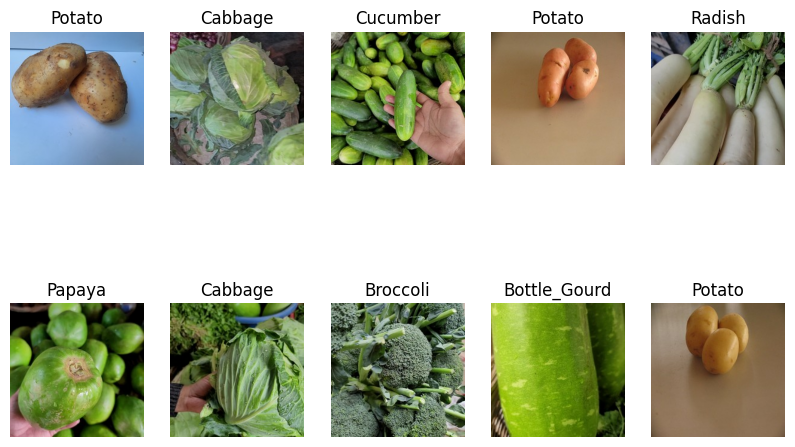

In [221]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        ax = plt.subplot(10 // 5 + 1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[np.argmax(labels[i])])
        plt.axis("off")

In [222]:
# Count the number of objects in each class for dataset splits
class_counts_train = {}
for images, labels in train_ds:
    for label in labels.numpy():
        class_index = label.argmax()  # Get the class index with the highest probability
        if class_index not in class_counts_train:
            class_counts_train[class_index] = 0
        class_counts_train[class_index] += 1


class_counts_validation = {}
for images, labels in val_ds:
    for label in labels.numpy():
        class_index = label.argmax()
        if class_index not in class_counts_validation:
            class_counts_validation[class_index] = 0
        class_counts_validation[class_index] += 1
      
    
class_counts_test = {}
for images, labels in test_ds:
    for label in labels.numpy():
        class_index = label.argmax()
        if class_index not in class_counts_test:
            class_counts_test[class_index] = 0
        class_counts_test[class_index] += 1
        
print(class_counts_train)
print(class_counts_validation)
print(class_counts_test)

{7: 1000, 14: 1000, 6: 1000, 5: 1000, 2: 1000, 8: 1000, 1: 1000, 11: 1000, 13: 1000, 9: 1000, 12: 1000, 4: 1000, 10: 1000, 3: 1000, 0: 1000}
{11: 200, 8: 200, 12: 200, 5: 200, 13: 200, 4: 200, 1: 200, 14: 200, 9: 200, 7: 200, 6: 200, 3: 200, 0: 200, 10: 200, 2: 200}
{11: 200, 8: 200, 12: 200, 5: 200, 13: 200, 4: 200, 1: 200, 14: 200, 9: 200, 7: 200, 6: 200, 3: 200, 0: 200, 10: 200, 2: 200}


In [223]:
# autotune datasets (or it`ll be a bottleneck)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [224]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [225]:
class TransferModel:
    def __init__(self,
                 base_model,
                 base_model_preprocess_input,
                 shape: tuple,
                 n_classes,
                 trainable=False,
                 dense_layer_neurons=8,
                 alpha=0.001,
                 dropout_rate=0.5):
        """
        Class for transfer learning based on InceptionV3
        
        Args:
            base_model: Base model object from tensorflow.keras.applications
            base_model_preprocess_input: required preprocessing for base_model
            shape: Input shape as tuple (height, width, channels)
            n_classes: Amount of classes in data
            trainable: Boolean, trainable or frozen base model (False by default)
            dense_layer_neurons: Int amount of neurons in dense layer (8 by default)
            alpha: Float, parameter alpha for L2 regularization
            dropout_rate: Float, probability of dropout for neurons in dense layer
        """
        self.base_model = base_model
        self.base_model_preprocess_input = base_model_preprocess_input
        self.shape = shape
        self.n_classes = n_classes
        self.trainable = trainable
        self.dense_layer_neurons = dense_layer_neurons
        self.alpha = alpha
        self.dropout_rate = dropout_rate
        self.class_names = class_names

        # set trainable param of base model
        self.base_model.trainable = self.trainable

        # create inputs and perform necessary preprocessing
        inputs = Input(shape=self.shape)
        preprocess = self.base_model_preprocess_input (inputs)
        
        x = self.base_model (preprocess)

        # create top layers
        x = BatchNormalization() (x)
        x = MaxPooling2D((2,2)) (x)
        x = Flatten()(x)

        x = Dense(16, activation = "gelu"
                  , kernel_regularizer=l2(self.alpha)) (x)
        x = Dropout(self.dropout_rate) (x)
        
        x = BatchNormalization() (x)
        x = Dense(8, activation = "gelu"
                  , kernel_regularizer=l2(self.alpha)) (x)
        x = Dropout(self.dropout_rate) (x)
        
        outputs = Dense(self.n_classes, activation='softmax') (x)

        self.model = Model(inputs=inputs, outputs=outputs)
        
    def compile_model(self, **kwargs):
        """
        Pass args to default compile method
        """
        self.model.compile(**kwargs)
        
    def fit(self, 
            train_ds, 
            val_ds, 
            epochs=1000,
            use_callbacks=True, 
            checkpoint_dir='checkpoints',
            patience=10,
            verbose=1,
            **kwargs):
        """
        Train model and create callbacks
        
        Args:
            train_ds: training dataset (e.g. BatchDataset)
            val_ds: validation dataset (e.g. BatchDataset)
            epochs: Int, amount of epochs to train model
            use_callbacks: Boolean, use callbacks or nor (True by default)
            checkpoint_dir: String, specify directory to store checkpoints
                            not necessary if use_callback=False ('checkpoints' by default)
            patience: Int, set patience parameter for early_stopping callback
                            not necessary if use_callback=False (10 by default)
            verbose: Int, print info or not (1 by default)
            
        Returns:
            Training history from self.history
        """
        
        # check if using callbacks
        if use_callbacks:
            # create checkpoint_dir id it doesn`t exist
            if not os.path.isdir(checkpoint_dir):
                os.mkdir(checkpoint_dir)
                
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.0001,
                patience=patience,
                verbose=verbose,
                mode="auto",
                restore_best_weights=True)
            
            filepath = checkpoint_dir+'/model_{epoch:02d}-{val_loss:.2f}.h5'
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=filepath,
                monitor="val_loss",
                verbose=verbose,
                save_best_only=True,
                save_weights_only=True,
                mode="auto",
                save_freq="epoch",
                initial_value_threshold=1.)
            
            callbacks = [checkpoint, early_stopping]
            
        else: 
            callbacks = None
            
        self.history = self.model.fit(train_ds,
                                      callbacks=callbacks,
                                      validation_data=val_ds,
                                      epochs=epochs,
                                      **kwargs)
        return self.history
    
    def evaluate(self, test_ds):
        """
        Evaluate trained model
        
        Args:
            test_ds: test dataset with labels (e.g. BatchDataset)
            
        Returns:
            y_true: True labels for test objects
            y_pred: Predicted labels for test objects
        """
        y_pred = np.argmax(self.model.predict(test_ds), axis=-1)

        y_pred = []
        y_true = np.array([])
        for image, label in test_ds:
            y_pred = np.concatenate([y_pred, np.argmax(self.model.predict(image), axis=-1)])
            y_true = np.concatenate([y_true, np.argmax(label.numpy(), axis=-1)])
        return y_true, y_pred

# InceptionV3

In [234]:
ResNet_base_model = applications.InceptionV3(weights='imagenet',
                                             include_top=False,
                                             input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
RN_preprocess = applications.inception_v3.preprocess_input

In [235]:
RN_model = TransferModel(ResNet_base_model,
                         RN_preprocess,
                         shape=(IMG_HEIGHT,IMG_WIDTH,3),
                         trainable=False,
                         n_classes=15,
                         dense_layer_neurons=8,
                         alpha=0.001,
                         dropout_rate=0.5)

In [236]:
RN_model.compile_model(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

In [237]:
RN_model.model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_29 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_29 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 batch_normalization_1093 (B  (None, 5, 5, 2048)       8192      
 atchNormalization)                                              
                                                          

In [238]:
RN_history = RN_model.fit(train_ds=train_ds, 
                          val_ds=val_ds, 
                          epochs=15,
                          use_callbacks=True, 
                          checkpoint_dir='checkpoints_RN',
                          patience=5,
                          verbose=1)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 2.2980 - accuracy: 0.2444
Epoch 1: val_loss did not improve from 1.00000
235/235 [==============================] - 27s 100ms/step - loss: 2.2980 - accuracy: 0.2444 - val_loss: 1.6049 - val_accuracy: 0.8313
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 2.0299 - accuracy: 0.3189
Epoch 2: val_loss did not improve from 1.00000
235/235 [==============================] - 20s 87ms/step - loss: 2.0299 - accuracy: 0.3189 - val_loss: 1.2455 - val_accuracy: 0.9353
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 1.9045 - accuracy: 0.3608
Epoch 3: val_loss did not improve from 1.00000
235/235 [==============================] - 20s 84ms/step - loss: 1.9045 - accuracy: 0.3608 - val_loss: 1.0645 - val_accuracy: 0.9663
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 1.8361 - accuracy: 0.3895
Epoch 4: val_loss improved from 1.00000 to 0.98579, saving model to checkpo

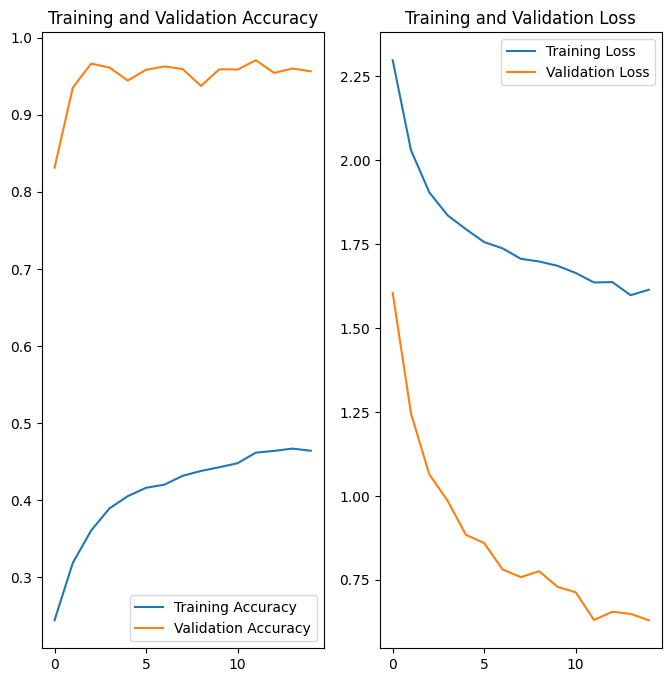

In [239]:
plot_history(RN_history)

In [240]:
y_true, y_pred = RN_model.evaluate(test_ds)

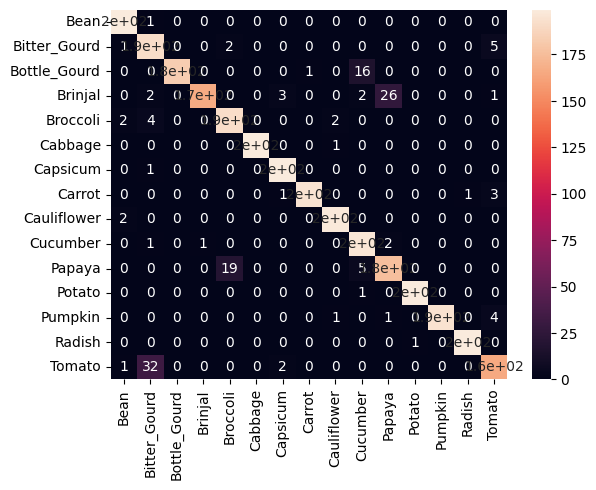

In [241]:
conf = confusion_matrix(y_true, y_pred)
_ = sns.heatmap(conf, annot=True, yticklabels=class_names, xticklabels=class_names)

In [242]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       200
         1.0       0.82      0.96      0.89       200
         2.0       1.00      0.92      0.96       200
         3.0       0.99      0.83      0.90       200
         4.0       0.90      0.96      0.93       200
         5.0       1.00      0.99      1.00       200
         6.0       0.97      0.99      0.98       200
         7.0       0.99      0.97      0.98       200
         8.0       0.98      0.99      0.99       200
         9.0       0.89      0.98      0.93       200
        10.0       0.86      0.88      0.87       200
        11.0       0.99      0.99      0.99       200
        12.0       1.00      0.97      0.98       200
        13.0       0.99      0.99      0.99       200
        14.0       0.93      0.82      0.87       200

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95   